# Playground

## General Preparation

Load the meta-data and the file names of the documents.
It is important to ensure that the file names have the same order in the list as in the meta-data.
Otherwise, class assignment would be messed up.

In [1]:
import glob
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation
from sklearn.decomposition import TruncatedSVD
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, matthews_corrcoef, normalized_mutual_info_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

data_dir = 'data/corpus/'
file_info = pd.read_csv(data_dir + 'file_info.csv', sep = '|')
text_files = glob.glob(data_dir + '*.txt')
assert [os.path.basename(x) for x in text_files] == file_info.output_file.tolist()

## Exploring the Meta-Data

Currently, we don't have much meta-information.
Only the class labels are in a usable form.
Type of work and publication date could be extracted from the original file name, but are not harmonized.
Anyway, the subsequent analysis should focus on the content (raw text), not the meta-data.

In [2]:
file_info.head()

,input_file,output_file,author
0,htm_a_chapter_of_the_social_system,text_000.txt,htm
1,htm_charlatanism_1831,text_001.txt,htm
2,htm_draft_1_writings_on_education_of_women_1832,text_002.txt,htm
3,htm_draft_1_writings_on_ethics_1831,text_003.txt,htm
4,htm_draft_1_writings_on_marriage_and_divorce_1831,text_004.txt,htm


The class distribution is skewed:

author
htm         52
htm+jsm     23
jsm        304
dtype: int64


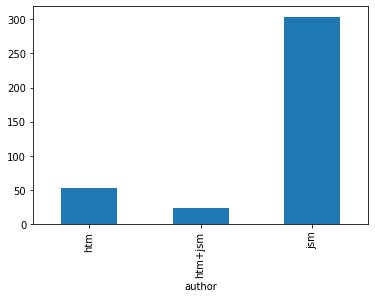

In [3]:
author_count = file_info.groupby('author').agg('size')
print(author_count)
author_count.plot.bar()
plt.show()

## Comparing Different Cut-Offs for the Frequency Matrix

Generating word-frequency features, we vary the minimm number of documents a word needs to appear in to become a feature.

   cut-off  features
0        1     31541
1        2     18957
2        4     12450
3        8      8004
4       16      4708
5       32      2498
6       64      1070
7      128       373
8      256        83


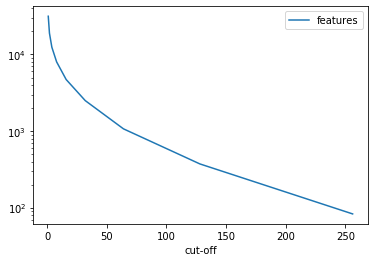

In [4]:
results = []
for cut_off in [2 ** x for x in range(0, int(math.log2(len(text_files))) + 1)]:
    vectorizer = CountVectorizer(input='filename', min_df=cut_off)
    vectorizer.fit(text_files)
    results.append({'cut-off': cut_off, 'features': len(vectorizer.get_feature_names())})
results = pd.DataFrame(results)
print(results)
results.plot.line(x='cut-off', y='features', logy=True)
plt.show()

## Pre-Processing + Exploring the Frequency Matrix

Again, we generate word-frequency features and now take a closer look at the resulting matrix.

In [5]:
vectorizer = TfidfVectorizer(input='filename', min_df=10, use_idf=False, norm='l1')
frequency_matrix = vectorizer.fit_transform(text_files)
print('The frequency matrix has the type ' + str(type(frequency_matrix)) + '.')
print('Its dimensionality is ' + str(frequency_matrix.shape) + '.')
print('Normalization - the overall sum of the matrix is ' + str(frequency_matrix.sum().sum()) + '.')
print('There are ' + str(len(vectorizer.get_feature_names())) + ' different words, the first 10 being ' +
      ', '.join(vectorizer.get_feature_names()[0:10]) + ' and the last 10 being ' +
      ', '.join(vectorizer.get_feature_names()[-10:]))

The frequency matrix has the type <class 'scipy.sparse.csr.csr_matrix'>.
Its dimensionality is (379, 6824).
Normalization - the overall sum of the matrix is 379.00000000000006.
There are 6824 different words, the first 10 being 000, 10, 100, 11, 12, 13, 14, 15, 16, 1688 and the last 10 being younger, your, yours, yourself, yourselves, youth, youthful, zeal, zealous, élite


We use the word-frequency features to conduct classification and clustering.
We encode the class labels as integers starting from zero.

In [6]:
label_encoder = LabelEncoder()
X = frequency_matrix
y = label_encoder.fit_transform(file_info.author)

### Plotting the Frequency Matrix

If we reduce dimensionality, we can also plot the frequency matrix.

Variance explained: 6.9%, 8.83%


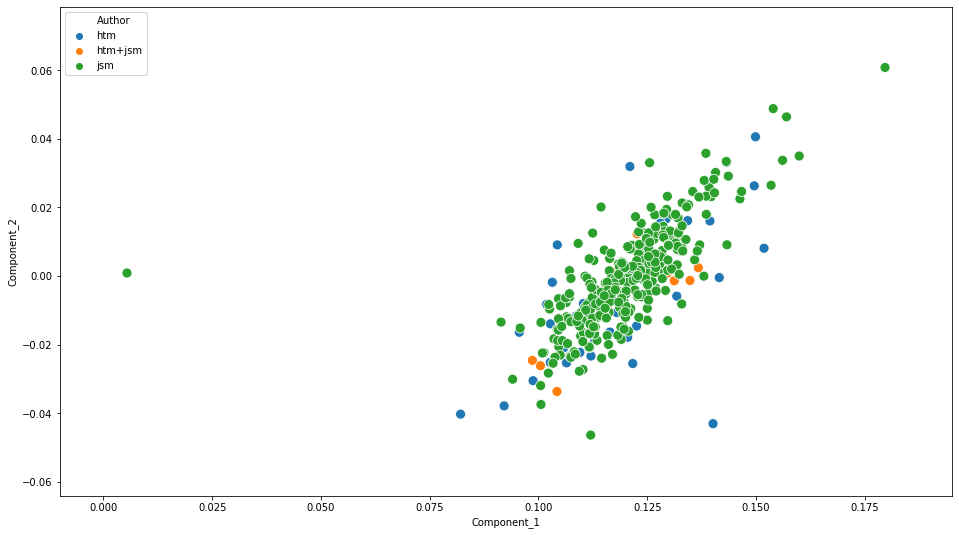

In [7]:
svd = TruncatedSVD(n_components=2, random_state=25)
red_matrix = svd.fit_transform(frequency_matrix)
print('Variance explained: ' + ', '.join([str(round(x * 100, 2)) + '%' for x in svd.explained_variance_ratio_]))
red_data = pd.DataFrame(red_matrix, columns=['Component_1', 'Component_2'])
red_data['Author'] = file_info.author
plt.figure(figsize=(16,9))
sns.scatterplot(data=red_data, x='Component_1', y='Component_2', hue='Author', s=100)
plt.show()

## Predicting Authorship

As a baseline, we would predict the most frequent class.
This can easily be done by hand or using `sklearn`'s `DummyClassifier`.

In [8]:
baseline_pred = [np.bincount(y).argmax()] * len(y)
print('Baseline accuracy: ' + str(round(accuracy_score(y_true=y, y_pred=baseline_pred), 3)))
print('Baseline MCC: ' + str(round(matthews_corrcoef(y_true=y, y_pred=baseline_pred), 3)))
print('Baseline classification report:')
print(classification_report(y_true=y, y_pred=baseline_pred))

Baseline accuracy: 0.802
Baseline MCC: 0.0
Baseline classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.00      0.00      0.00        23
           2       0.80      1.00      0.89       304

    accuracy                           0.80       379
   macro avg       0.27      0.33      0.30       379
weighted avg       0.64      0.80      0.71       379



C:\MyData\Anaconda3\envs\agdlab_20\lib\site-packages\sklearn\metrics\_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\MyData\Anaconda3\envs\agdlab_20\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We conduct a cross-validation.
The model can be exchanged easily.

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=25)
splits = cv.split(X=y, y=y) # X required, but not used
train_acc = []
test_acc = []
train_mcc = []
test_mcc = []
for train_idx, test_idx in splits:
    # other (imported) classifiers: LogisticRegression(), DecisionTreeClassifier(), DummyClassifier(strategy='most_frequent')
    model = xgb.XGBClassifier(random_state=25, n_estimators=20)
    model.fit(X=X[train_idx, :], y=y[train_idx])
    train_predictions = model.predict(X[train_idx, :])
    train_acc.append(accuracy_score(y_true=y[train_idx], y_pred=train_predictions))
    train_mcc.append(matthews_corrcoef(y_true=y[train_idx], y_pred=train_predictions))
    test_predictions = model.predict(X[test_idx, :])
    test_acc.append(accuracy_score(y_true=y[test_idx], y_pred=test_predictions))
    test_mcc.append(matthews_corrcoef(y_true=y[test_idx], y_pred=test_predictions))
print('Train accuracy: ' + str(round(sum(train_acc) / len(train_acc), 3)))
print('Test accuracy: ' + str(round(sum(test_acc) / len(test_acc), 3)))
print('Train MCC: ' + str(round(sum(train_mcc) / len(train_mcc), 3)))
print('Test MCC: ' + str(round(sum(test_mcc) / len(test_mcc), 3)))

Train accuracy: 1.0
Test accuracy: 0.913
Train MCC: 1.0
Test MCC: 0.717


## Clustering Authorship

We create a clustering based on the word-frequency matrix and evaluate with an external validity index against the ground truth.
`sklearn` supplies several distance metrics, clustering algorithm and (internal as well as external) validity indices.
Only some of the clustering algorithms allow for a variation in the distance metric, and some others even allow an arbitrary distance matrix.

### Agglomerative Hierarchical Clustering

Clustering high-dimensional data is hard ...

In [10]:
model = AgglomerativeClustering(n_clusters=3, affinity='cosine', linkage='average')
model.fit(X=X.toarray())
print('Contingency matrix (rows = true, columns = predicted):')
print(contingency_matrix(labels_true=y, labels_pred=model.labels_))
print('Normalized Mutual Information: ' + str(round(normalized_mutual_info_score(
    labels_true=y, labels_pred=model.labels_), 3)))

Contingency matrix (rows = true, columns = predicted):
[[ 51   0   1]
 [ 23   0   0]
 [303   1   0]]
Normalized Mutual Information: 0.018


### Affinity Propagation

In [11]:
similarity_matrix = cosine_similarity(X)
model = AffinityPropagation()
model.fit(X=similarity_matrix)
print('Contingency matrix (rows = true, columns = predicted):')
print(contingency_matrix(labels_true=y, labels_pred=model.labels_))
print('Normalized Mutual Information: ' + str(round(normalized_mutual_info_score(
    labels_true=y, labels_pred=model.labels_), 3)))

Contingency matrix (rows = true, columns = predicted):
[[ 1  4  4  2  1  3  1  1  4  1  1  4  5  1  1  0  0  1  0  0  2  2  1  1
   3  0  1  2  0  1  1  2  1  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  2  0  1  0  0  0  6  0  3  1
   0  0  1  2  0  1  0  3  2  0]
 [ 0  2  1  0  0  2  0  1  1  0  2 15  0  8 29  3  6  6 10  1 28  5 13 25
   7  1  4 28 23 15 24 16 19  9]]
Normalized Mutual Information: 0.106
